In [1]:
import pandas as pd
import numpy as np
seed = np.random.seed(42)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',50)

%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer,StandardScaler,LabelEncoder
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE

#f1_scorer = make_scorer(f1_score, average='macro',labels=Y.unique().tolist())
#myscorer = f1_scorer
myscorer = 'accuracy'

/Users/refikcanmalli/anaconda3/envs/vodafone/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
cdata = pd.read_csv('../data/central' +'_data.csv')
cdata.shape

(275, 73)

In [4]:
h1_p = pd.read_csv('../data/host1_predictions.csv')
h2_p = pd.read_csv('../data/host2_predictions.csv')
h3_p = pd.read_csv('../data/host3_predictions.csv')
h1_a = np.load('../data/host1_acc.npy')
h2_a = np.load('../data/host2_acc.npy')
h3_a = np.load('../data/host3_acc.npy')

In [5]:
h2_p.head(3)

,host2
0,1.0
1,1.0
2,0.0


In [6]:
data_e = cdata[cdata['IPG'] != 1]
data_e = data_e.drop('IPG', axis = 1);
data_e = data_e.drop('sbjBeatConsidered', axis = 1);
data_e = data_e.drop('numRRaveraged', axis = 1);
data_e = data_e.drop('Soggetti', axis = 1);
# df_columns = data.columns.tolist()
# matching_columns1 = [s for s in df_columns if "Parea" in s]
# matching_columns2 = [s for s in df_columns if "Pdur" in s]
# mc = matching_columns1 + matching_columns2
# data_e = data_e.dropna(subset=mc)
data_e['PCneg'].fillna(0, inplace=True)
data_e['AFclass'].replace('persistierend (>7 Tage, EKV)', 1, inplace=True)
data_e['AFclass'].replace('paroxysmal', 0, inplace=True)
categorical_variables_mask = data_e.dtypes==object
categorical_variables = data_e.columns[categorical_variables_mask]
for v in categorical_variables:
    data_e[v] = LabelEncoder().fit_transform(data_e[v])
del categorical_variables_mask,categorical_variables
data_e = pd.DataFrame(data=MICE(n_imputations=100, impute_type='col', n_nearest_columns=5).complete(data_e.as_matrix()), columns=data_e.columns, index=data_e.index);
cy_df = data_e['AFclass'].copy()
cx_df = data_e.drop('AFclass',axis=1, inplace=False)

[MICE] Completing matrix with shape (270, 69)
[MICE] Starting imputation round 1/110, elapsed time 0.003
[MICE] Starting imputation round 2/110, elapsed time 0.027
[MICE] Starting imputation round 3/110, elapsed time 0.052
[MICE] Starting imputation round 4/110, elapsed time 0.090
[MICE] Starting imputation round 5/110, elapsed time 0.115
[MICE] Starting imputation round 6/110, elapsed time 0.138
[MICE] Starting imputation round 7/110, elapsed time 0.161
[MICE] Starting imputation round 8/110, elapsed time 0.184
[MICE] Starting imputation round 9/110, elapsed time 0.209
[MICE] Starting imputation round 10/110, elapsed time 0.249
[MICE] Starting imputation round 11/110, elapsed time 0.271
[MICE] Starting imputation round 12/110, elapsed time 0.294
[MICE] Starting imputation round 13/110, elapsed time 0.317
[MICE] Starting imputation round 14/110, elapsed time 0.340
[MICE] Starting imputation round 15/110, elapsed time 0.363
[MICE] Starting imputation round 16/110, elapsed time 0.386
[MI

In [7]:
h1_a

array(0.68888889)

In [8]:
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split

input_p = pd.concat([h1_p, h2_p, h3_p],axis=1)
indices = np.arange(input_p.shape[0])
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(input_p, cy_df,indices, test_size=0.3,stratify=cy_df, random_state=42)


In [9]:
param_grid = {"clf__max_depth": [10,30,50],
              "clf__criterion": ['gini', 'entropy'],
              "clf__n_estimators": [100,200,500,1000],
              "clf__random_state": [42],
              "clf__class_weight" : [None, 'balanced']}
# param_grid = {"classifier__max_depth": [30],
#               "classifier__n_estimators": [1000]}


rf = RandomForestClassifier()

plist = []
plist.append(('clf', rf))
pipeline = Pipeline(plist)
gs_rf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=1, scoring=myscorer, n_jobs=-1)

In [10]:
gs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.2min finished


In [11]:
gs_rf.best_params_

{'clf__class_weight': None,
 'clf__criterion': 'gini',
 'clf__max_depth': 10,
 'clf__n_estimators': 100,
 'clf__random_state': 42}

In [12]:
gs_rf.best_score_

0.6349206349206349

In [27]:
p = gs_rf.predict(X_test)
from sklearn.metrics import accuracy_score
c_acc_score = accuracy_score(y_test, p)
h1_acc_score = accuracy_score(input_p.values[ind_test,0], y_test)
h2_acc_score = accuracy_score(input_p.values[ind_test,1], y_test)
h3_acc_score = accuracy_score(input_p.values[ind_test,2], y_test)




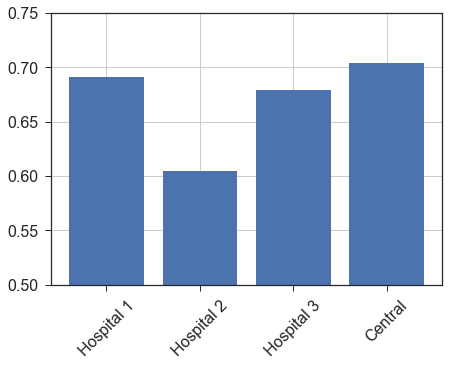

In [31]:
x = np.arange(4)
fig, ax = plt.subplots();
ax.set_ylim([0.5,0.75]);
fig.set_size_inches(7, 5);
plt.grid();
plt.bar(x, [h1_acc_score, h2_acc_score,h3_acc_score, c_acc_score]);
plt.xticks(x, ('Hospital 1','Hospital 2','Hospital 3','Central'),fontsize=16, rotation=45);
plt.yticks(fontsize=16);
